<a href="https://colab.research.google.com/github/mbabar1100/AIandMLforDiseaseDetection/blob/main/MastersThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Detection of TB Co-infection in HIV/AIDS Patients


This notebook demonstrates the process of building and evaluating various machine learning models to predict TB positive cases using a dataset of HIV/TB patients.

Step 1: Importing Libraries
We start by importing the necessary libraries for data manipulation, visualization, and machine learning.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas as gpd
import folium
from google.colab import files
warnings.filterwarnings('ignore')
!pip install shap
!pip install lime
!pip install geopandas folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d1fc551c83ecffc90bd63caa2c3c8e22e797664cdcc59e066ca3d0ce5dca3520
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Step 2: Reading and Preparing the Dataset

We read the dataset and perform basic data preprocessing, including handling missing values and converting categorical variables.


In [ ]:
# Reading the dataset
df = pd.read_csv('/content/FinalHIVTBDataV3.csv')

# Dropping rows beyond the first 81,643 records
df = df.iloc[:81643]

# Display the basic information about the dataframe
df.info()
df
print(df.describe())

# Handling Missing Values (example: filling NaNs with a placeholder)
df.fillna('Unknown', inplace=True)

# Convert 'TBPositive' to binary
df['TBPositive'] = df['TBPositive'].map({'Yes': 1, 'No': 0})

numerical_cols = ['Age', 'Weight_KGs', 'BISPDistrictPovertyPerc']
categorical_features = ['Gender', 'KeyPopulation', 'ModeOfTransmission', 'MaritalStatus', 'ARTStatus', 'AliveOrDead', 'ChildOrAdult', 'LostToFollowUp', 'Education', 'District', 'Province', 'Occupation', 'ReferedBy', 'SubstanceAbuse', 'OtherCoinfections']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81642 entries, 0 to 81641
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PLHIVID                  81642 non-null  int64  
 1   Gender                   81642 non-null  object 
 2   KeyPopulation            81642 non-null  object 
 3   ModeOfTransmission       81642 non-null  object 
 4   MaritalStatus            81642 non-null  object 
 5   ARTStatus                81642 non-null  object 
 6   AliveOrDead              81642 non-null  object 
 7   ChildOrAdult             81642 non-null  object 
 8   LostToFollowUp           81642 non-null  object 
 9   Age                      81642 non-null  int64  
 10  Education                81642 non-null  object 
 11  District                 81642 non-null  object 
 12  Province                 81642 non-null  object 
 13  Occupation               81642 non-null  object 
 14  ReferedBy             

## Step 3: Data Preprocessing

We define transformers for numerical and categorical features and create a preprocessing pipeline.


In [ ]:
# Upload the shapefile components
uploaded = files.upload()# Calculate the total number of TBPositive cases across the country
# Aggregate all cases by district (assuming 'District' column exists)
district_cases = df.groupby('District').size().reset_index(name='TotalCases')
district_positive_cases = df.groupby('District')['TBPositive'].sum().reset_index(name='PositiveCases')

# Merge the total cases and positive cases by district
district_cases = pd.merge(district_cases, district_positive_cases, on='District')

# Load the GeoJSON file for Pakistan's districts
geojson_path = 'pakistan_districts_province_boundries.geojson'
gdf = gpd.read_file(geojson_path)

# Set the CRS for the GeoDataFrame (if not set)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)  # Assuming WGS 84

# Convert all Timestamp objects to string format
def convert_timestamps_to_string(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(str)
    return df

gdf = convert_timestamps_to_string(gdf)

# Inspect the columns in the GeoDataFrame
print(gdf.columns)

# Identify the correct column for district names
district_column = 'districts'  # Column name for districts in the GeoDataFrame

# Ensure matching by standardizing names
gdf[district_column] = gdf[district_column].str.lower().str.strip()
district_cases['District'] = district_cases['District'].str.lower().str.strip()

# Merge the GeoDataFrame with the district cases data
gdf = gdf.merge(district_cases, left_on=district_column, right_on='District')

# Create a map centered around Pakistan
pakistan_center = [30.3753, 69.3451]  # Approximate center of Pakistan
m = folium.Map(location=pakistan_center, zoom_start=5)

# Define a function to get color based on the total number of cases
def get_color(total_cases):
    if total_cases > 1000:
        return '#d73027'  # Red
    elif total_cases > 500:
        return '#fc8d59'  # Light Red
    elif total_cases > 200:
        return '#fee08b'  # Yellow
    elif total_cases > 100:
        return '#d9ef8b'  # Light Green
    elif total_cases > 50:
        return '#91cf60'  # Green
    else:
        return '#1a9850'  # Dark Green

def style_function(feature):
    total_cases = feature['properties']['TotalCases']
    return {
        'fillColor': get_color(total_cases),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7  # Slightly more opaque for better visibility
    }

# Add the polygons to the map with updated style function
geo_json = folium.GeoJson(
    gdf,
    name='Pakistan Districts',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['districts', 'TotalCases', 'PositiveCases'],
        aliases=['District', 'Total Cases', 'Positive Cases']
    )
)

geo_json.add_to(m)

# Add a legend to the map for better interpretation
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 170px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     &nbsp; <strong>Total Cases Legend</strong> <br>
     &nbsp; <i style="background:#d73027; width: 18px; height: 18px; display: inline-block;"></i> > 1000 <br>
     &nbsp; <i style="background:#fc8d59; width: 18px; height: 18px; display: inline-block;"></i> 501 - 1000 <br>
     &nbsp; <i style="background:#fee08b; width: 18px; height: 18px; display: inline-block;"></i> 201 - 500 <br>
     &nbsp; <i style="background:#d9ef8b; width: 18px; height: 18px; display: inline-block;"></i> 101 - 200 <br>
     &nbsp; <i style="background:#91cf60; width: 18px; height: 18px; display: inline-block;"></i> 51 - 100 <br>
     &nbsp; <i style="background:#1a9850; width: 18px; height: 18px; display: inline-block;"></i> 0 - 50 <br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Save and display the map
m.save('pakistan_district_total_cases_map.html')
m

Saving pakistan_districts_province_boundries.geojson to pakistan_districts_province_boundries.geojson
Index(['objectid', 'province_territory', 'districts', 'shape_leng',
       'shape_area', 'district_agency', 'status', 'cartodb_id', 'created_at',
       'updated_at', 'geometry'],
      dtype='object')


In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0  # Ensures output is a DataFrame
)
# Create a pipeline that first preprocesses the data then fits the model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


## Step 4: Splitting the Data

We split the data into training and test sets.


In [ ]:
X = df[categorical_features + numerical_cols]
y = df['TBPositive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensuring X_train and X_test are DataFrames with appropriate columns
X_train = pd.DataFrame(X_train, columns=categorical_features + numerical_cols)
X_test = pd.DataFrame(X_test, columns=categorical_features + numerical_cols)


## Step 5: Exploratory Data Analysis



We perform exploratory data analysis to understand the distribution of TB positive cases across various features.


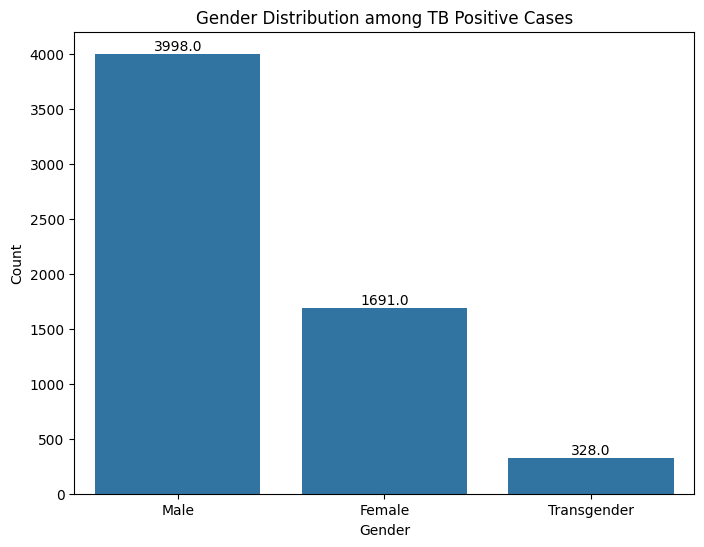

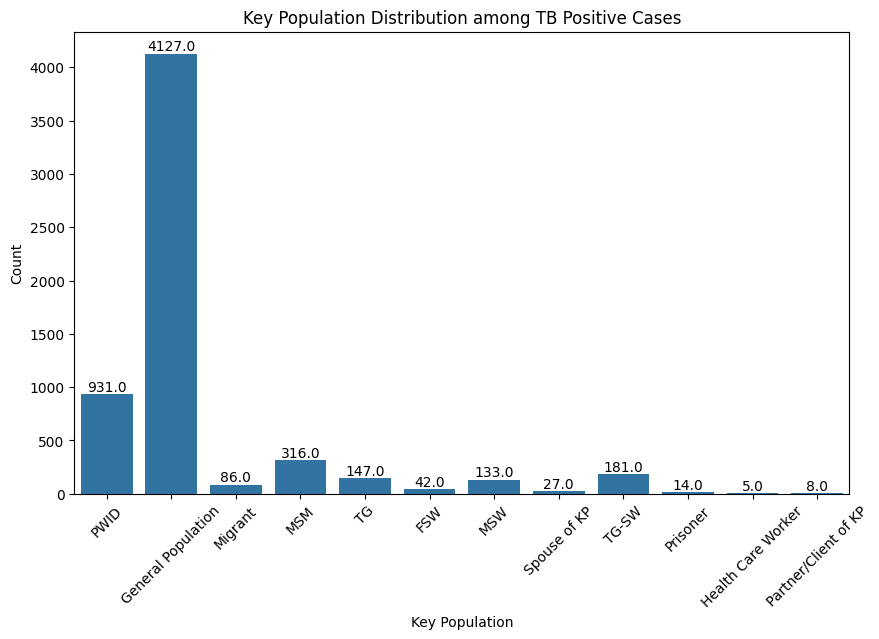

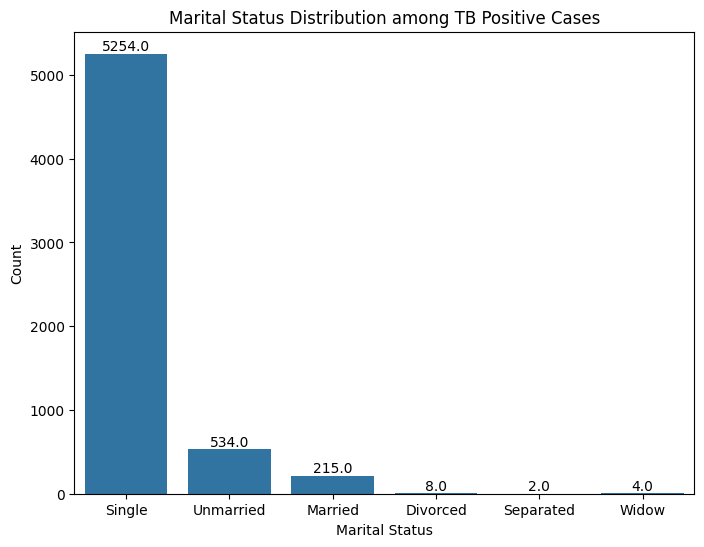

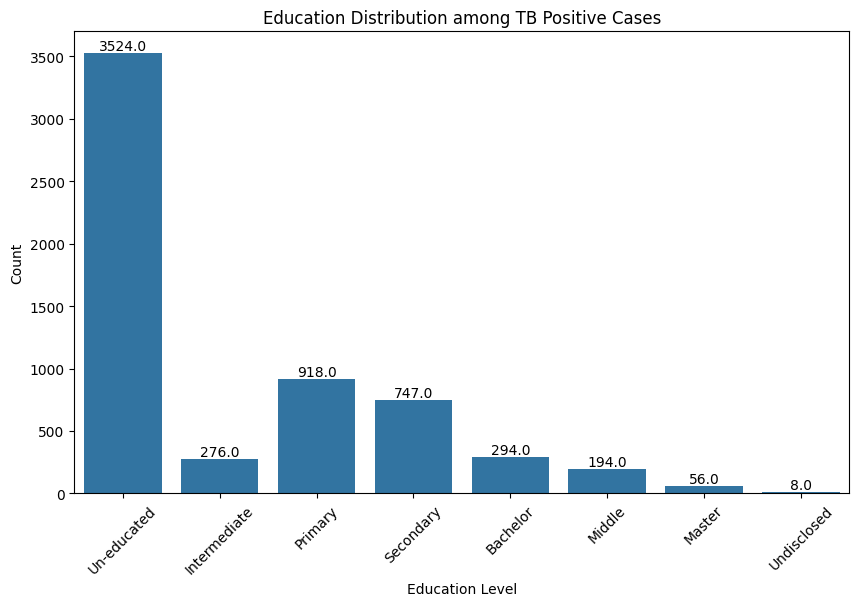

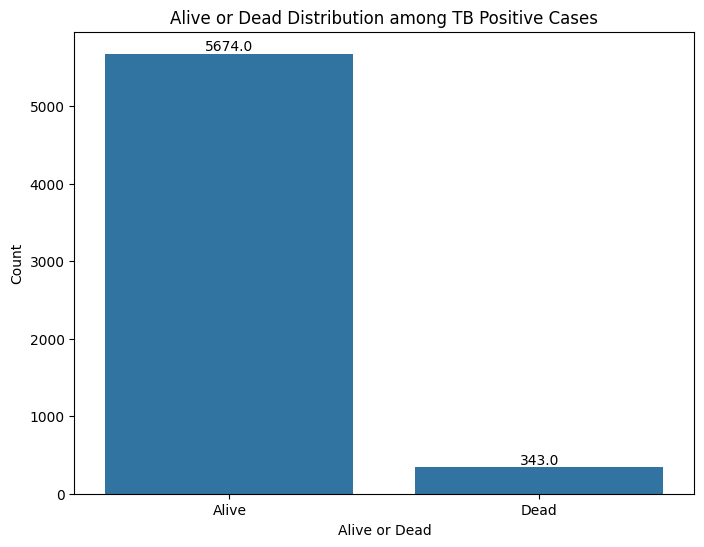

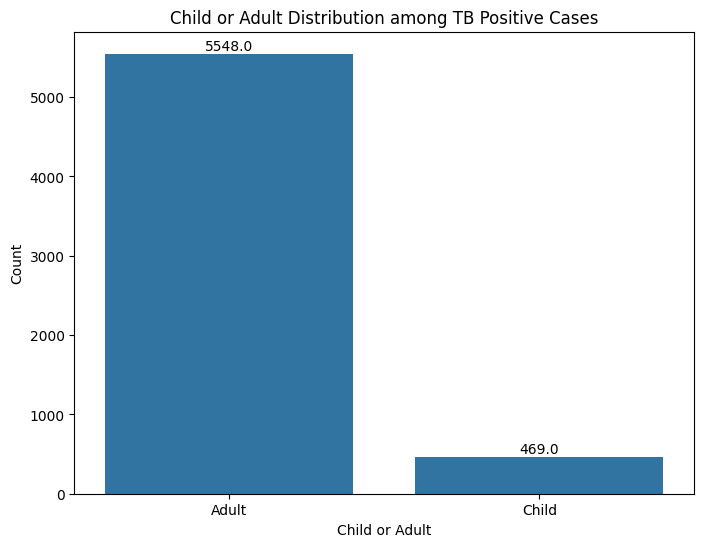

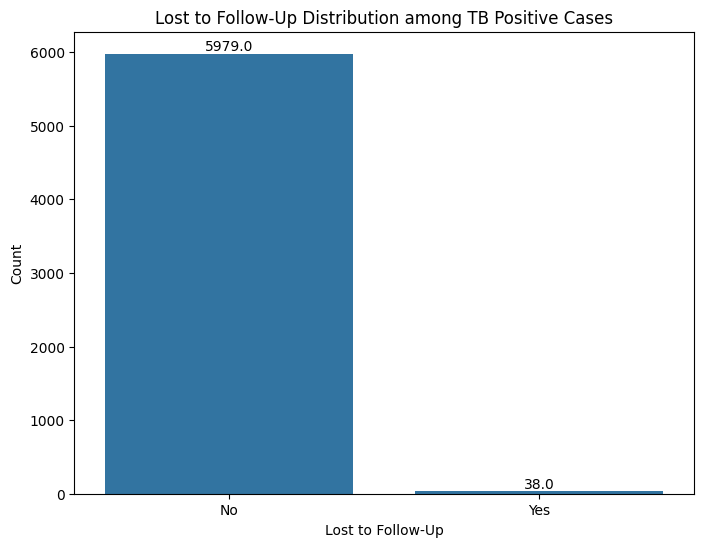

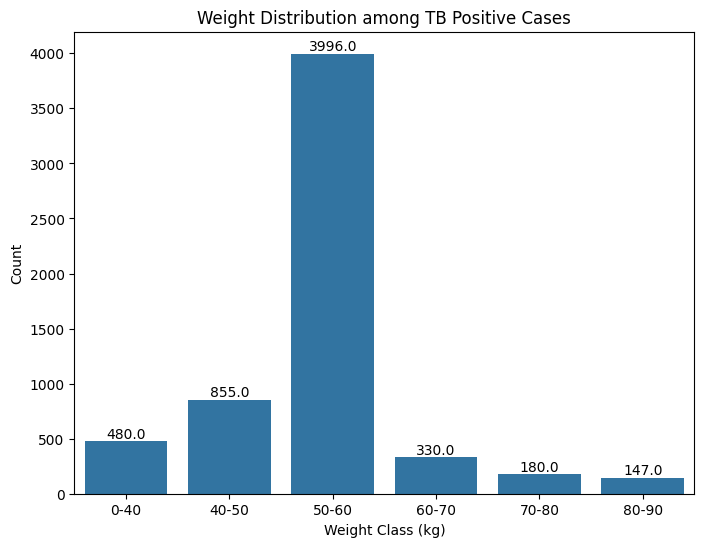

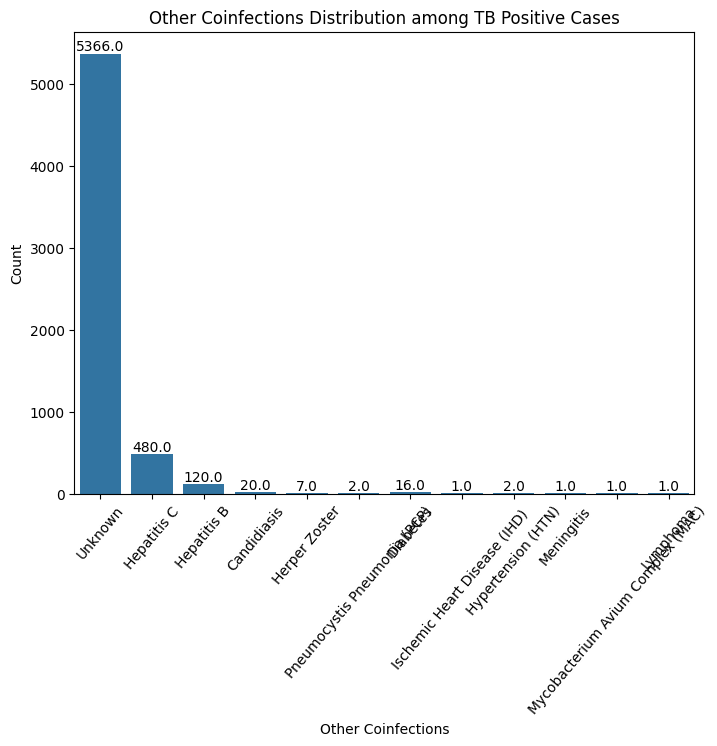

In [ ]:
# Function to add counts on top of the bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Gender Distribution among TB Positive Cases
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Gender', data=df[df['TBPositive'] == 1])
plt.title('Gender Distribution among TB Positive Cases')
plt.xlabel('Gender')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# Key Population Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='KeyPopulation', data=df[df['TBPositive'] == 1])
plt.title('Key Population Distribution among TB Positive Cases')
plt.xlabel('Key Population')
plt.ylabel('Count')
plt.xticks(rotation=45)
add_counts(ax)
plt.show()

# Marital Status Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='MaritalStatus', data=df[df['TBPositive'] == 1])
plt.title('Marital Status Distribution among TB Positive Cases')
plt.xlabel('Marital Status')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# Education Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Education', data=df[df['TBPositive'] == 1])
plt.title('Education Distribution among TB Positive Cases')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
add_counts(ax)
plt.show()

# Alive or Dead distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='AliveOrDead', data=df[df['TBPositive'] == 1])
plt.title('Alive or Dead Distribution among TB Positive Cases')
plt.xlabel('Alive or Dead')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# Child or Adult distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='ChildOrAdult', data=df[df['TBPositive'] == 1])
plt.title('Child or Adult Distribution among TB Positive Cases')
plt.xlabel('Child or Adult')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# Lost to Follow-Up distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='LostToFollowUp', data=df[df['TBPositive'] == 1])
plt.title('Lost to Follow-Up Distribution among TB Positive Cases')
plt.xlabel('Lost to Follow-Up')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# Weight distribution
# Define weight classes
weight_bins = [0, 40, 50, 60, 70, 80, 90]
weight_labels = ['0-40', '40-50', '50-60', '60-70', '70-80', '80-90']
# Categorize weights into bins
df['Weight_Class'] = pd.cut(df['Weight_KGs'], bins=weight_bins, labels=weight_labels, right=False)
# Plot the weight distribution among TB positive cases
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Weight_Class', data=df[df['TBPositive'] == 1])
plt.title('Weight Distribution among TB Positive Cases')
plt.xlabel('Weight Class (kg)')
plt.ylabel('Count')
add_counts(ax)
plt.show()

# OtherCoinfections distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='OtherCoinfections', data=df[df['TBPositive'] == 1])
plt.title('Other Coinfections Distribution among TB Positive Cases')
plt.xlabel('Other Coinfections')
plt.ylabel('Count')
plt.xticks(rotation=50)
add_counts(ax)
plt.show()


## Step 6: Model Training and Evaluation


We train various machine learning models and evaluate their performance using accuracy, precision, recall, F1-score, and ROC AUC.


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Neural Network': MLPClassifier(max_iter=1000)
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, auc, cm

# Evaluate all models and store the results
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    accuracy, precision, recall, f1, auc, cm = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm
    }

# Display the results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1-Score: {result['f1_score']:.2f}")
    print(f"AUC: {result['auc']:.2f}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n")


Model: Logistic Regression
Accuracy: 0.96
Precision: 0.77
Recall: 0.61
F1-Score: 0.68
AUC: 0.97
Confusion Matrix:
[[14962   213]
 [  455   699]]


Model: Random Forest
Accuracy: 0.98
Precision: 0.93
Recall: 0.85
F1-Score: 0.89
AUC: 0.99
Confusion Matrix:
[[15099    76]
 [  170   984]]


Model: Gradient Boosting
Accuracy: 0.99
Precision: 0.99
Recall: 0.89
F1-Score: 0.94
AUC: 1.00
Confusion Matrix:
[[15166     9]
 [  122  1032]]


Model: Support Vector Machine
Accuracy: 0.98
Precision: 0.94
Recall: 0.82
F1-Score: 0.88
AUC: 0.99
Confusion Matrix:
[[15119    56]
 [  207   947]]


Model: Neural Network
Accuracy: 0.98
Precision: 0.89
Recall: 0.87
F1-Score: 0.88
AUC: 0.99
Confusion Matrix:
[[15052   123]
 [  148  1006]]




## Step 7: Hyperparameter Tuning

We perform hyperparameter tuning for the Random Forest model using GridSearchCV.



In [ ]:
# Hyperparameter tuning (example for Random Forest)
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Check if grid search completed successfully
if hasattr(grid_search, 'best_estimator_'):
    best_model = grid_search.best_estimator_

    # Evaluate the tuned model
    accuracy, precision, recall, f1, auc, cm = evaluate_model(best_model, X_train, y_train, X_test, y_test)

    print("Tuned Random Forest Performance")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")
    print("Confusion Matrix:")
    print(cm)
else:
    print("Grid search did not complete successfully or best_estimator_ is not available.")


Best parameters found:  {'classifier__max_depth': 30, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation score:  0.865712204543555
Tuned Random Forest Performance
Accuracy: 0.98
Precision: 0.96
Recall: 0.80
F1-Score: 0.87
AUC: 0.99
Confusion Matrix:
[[15137    38]
 [  230   924]]


## Step 8: Feature Importance

We analyze the feature importances of the best model from the hyperparameter tuning.


                     Feature  Importance
1                 Weight_KGs    0.343418
0                        Age    0.142694
2    BISPDistrictPovertyPerc    0.032274
204     Province_BALOCHISTAN    0.028875
209          Province_PUNJAB    0.018483
168          District_QUETTA    0.017863
33         ARTStatus_Pre-ART    0.016990
28      MaritalStatus_Single    0.013402
32          ARTStatus_On-ART    0.013341
210           Province_SINDH    0.013216


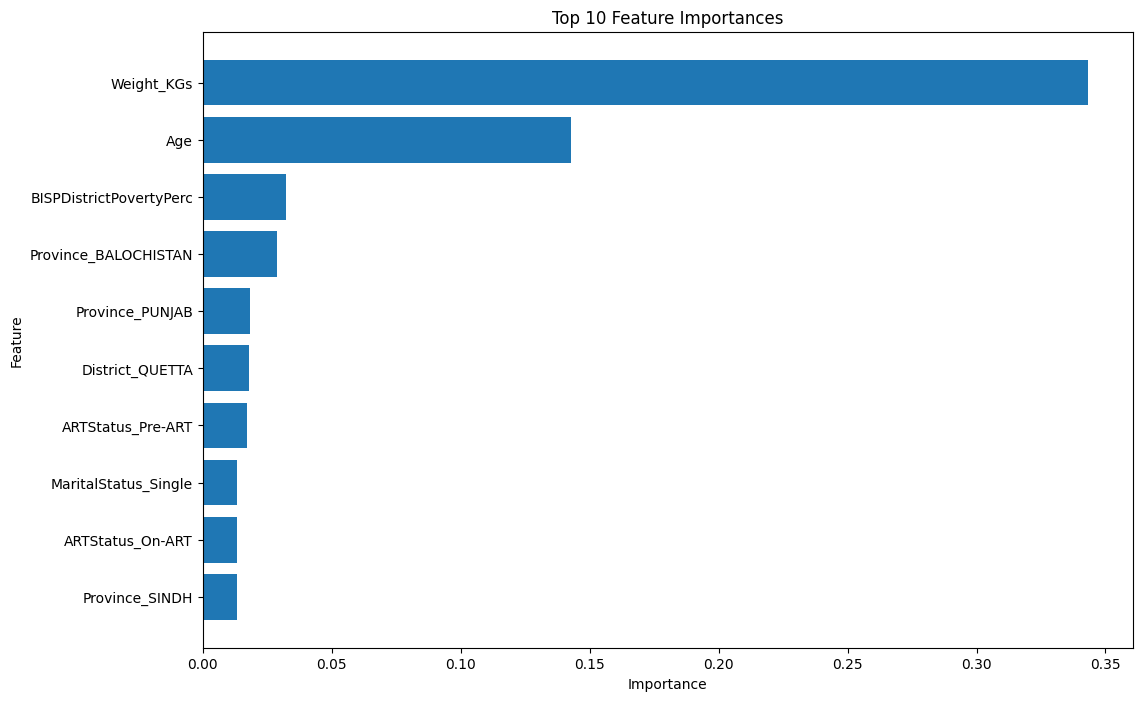

In [ ]:
# Fit the preprocessor separately
preprocessor.fit(X_train)

# Get the transformed feature names
if hasattr(preprocessor, 'transformers_'):
    feature_names = []
    for transformer_name, transformer, cols in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if transformer_name == 'remainder' and transformer == 'passthrough':
            feature_names.extend(cols)
        else:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)
else:
    feature_names = X_train.columns

# Extract the best model from the grid search
if hasattr(grid_search, 'best_estimator_'):
    best_model = grid_search.best_estimator_

    # Get the RandomForestClassifier from the pipeline
    rf_model = best_model.named_steps['classifier']

    # Retrieve feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the top 10 features
    top_features = feature_importance_df.head(10)

    # Print the top 10 feature importances
    print(top_features)

    # Plot the top 10 feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()  # Invert y axis to show the most important feature at the top
    plt.show()

else:
    print("Grid search did not complete successfully or best_estimator_ is not available.")


## Step 9: Visualization of Cross-Validation Results

We visualize the cross-validation results to understand the fit time and validation scores across different hyperparameter combinations.


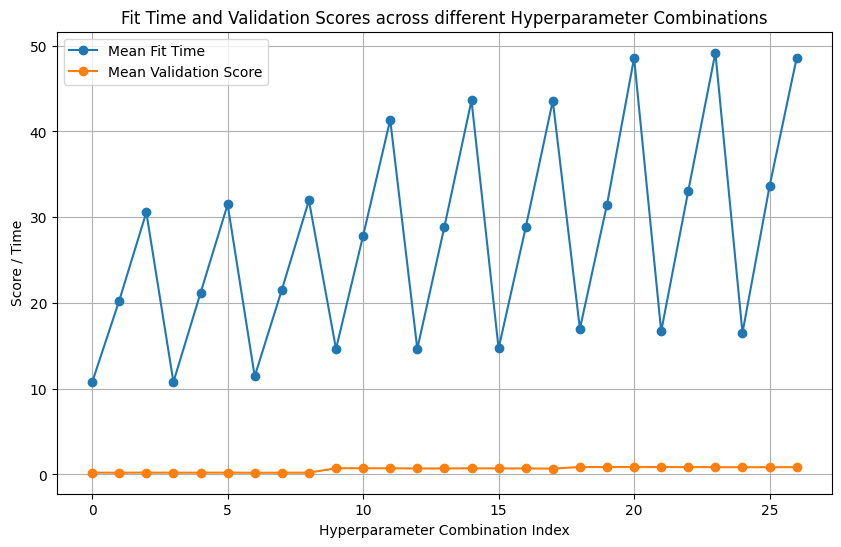

In [ ]:
# Ensure you have the grid_search object from your previous code
if hasattr(grid_search, 'cv_results_'):
    # Extract cross-validation results from GridSearchCV
    cv_results = pd.DataFrame(grid_search.cv_results_)

    # Extract mean fit and validation scores
    mean_fit_time = cv_results['mean_fit_time']
    mean_test_score = cv_results['mean_test_score']

    # Plot the fit time and validation accuracy scores
    plt.figure(figsize=(10, 6))
    plt.plot(mean_fit_time, label='Mean Fit Time', marker='o')
    plt.plot(mean_test_score, label='Mean Validation Score', marker='o')
    plt.xlabel('Hyperparameter Combination Index')
    plt.ylabel('Score / Time')
    plt.title('Fit Time and Validation Scores across different Hyperparameter Combinations')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Grid search did not complete successfully or cv_results_ is not available.")


## Step 10: Validation Loss Visualization

We visualize the validation loss across different hyperparameter combinations.


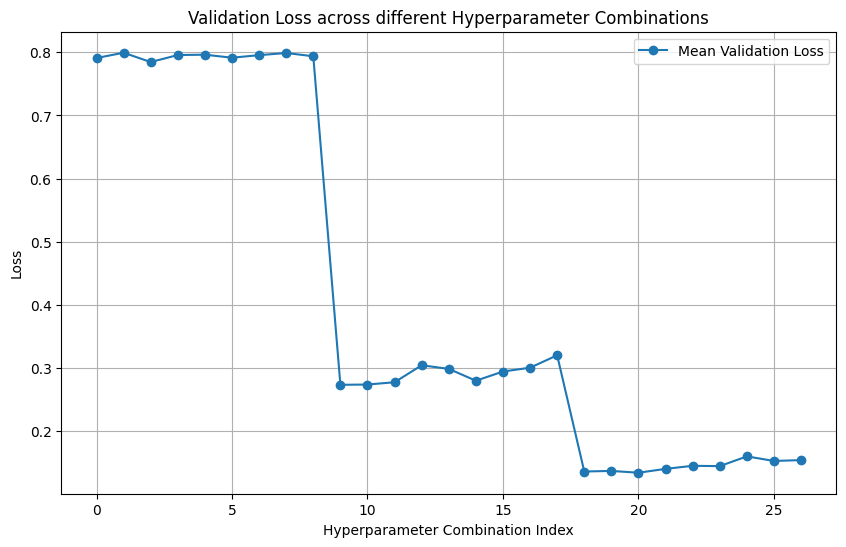

In [ ]:
# Ensure you have the grid_search object from your previous code
if hasattr(grid_search, 'cv_results_'):
    # Extract cross-validation results from GridSearchCV
    cv_results = pd.DataFrame(grid_search.cv_results_)

    # Extract mean test score
    mean_test_score = cv_results['mean_test_score']

    # Convert accuracy scores to loss (1 - accuracy)
    mean_test_loss = 1 - mean_test_score

    # Plot the validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(mean_test_loss, label='Mean Validation Loss', marker='o')
    plt.xlabel('Hyperparameter Combination Index')
    plt.ylabel('Loss')
    plt.title('Validation Loss across different Hyperparameter Combinations')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Grid search did not complete successfully or cv_results_ is not available.")


## Step 11: Model Comparison

We compare the accuracy of different models using a bar chart.


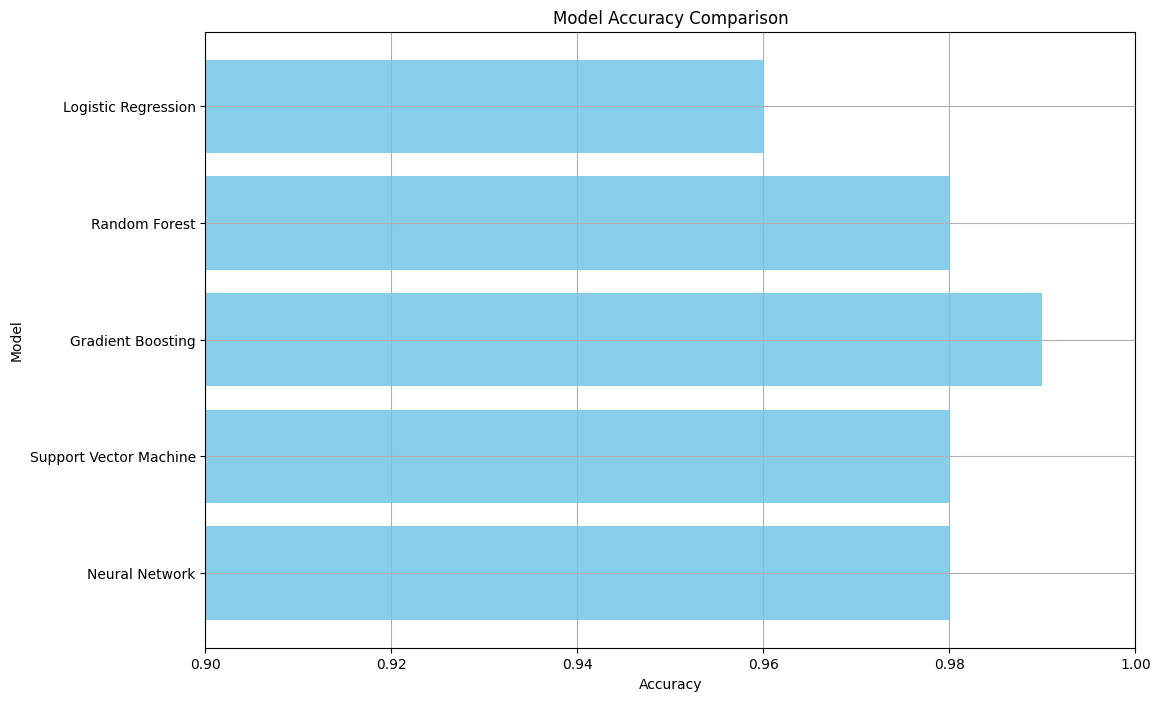

In [ ]:
# Assuming `results` is a dictionary with model names as keys and their accuracy as values
results = {
    'Logistic Regression': {'accuracy': 0.96},
    'Random Forest': {'accuracy': 0.98},
    'Gradient Boosting': {'accuracy': 0.99},
    'Support Vector Machine': {'accuracy': 0.98},
    'Neural Network': {'accuracy': 0.98}
}

# Extract model names and their accuracies
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

# Plot Model Accuracy Comparison
plt.figure(figsize=(12, 8))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
plt.xlim(0.9, 1.0)  # Assuming all accuracies are in the range of 0.9 to 1.0 for better visualization
plt.gca().invert_yaxis()  # Invert y axis to show the highest accuracy at the top
plt.grid(True)
plt.show()


## Step 12: ROC Curves

We plot ROC curves for each model to evaluate their performance.


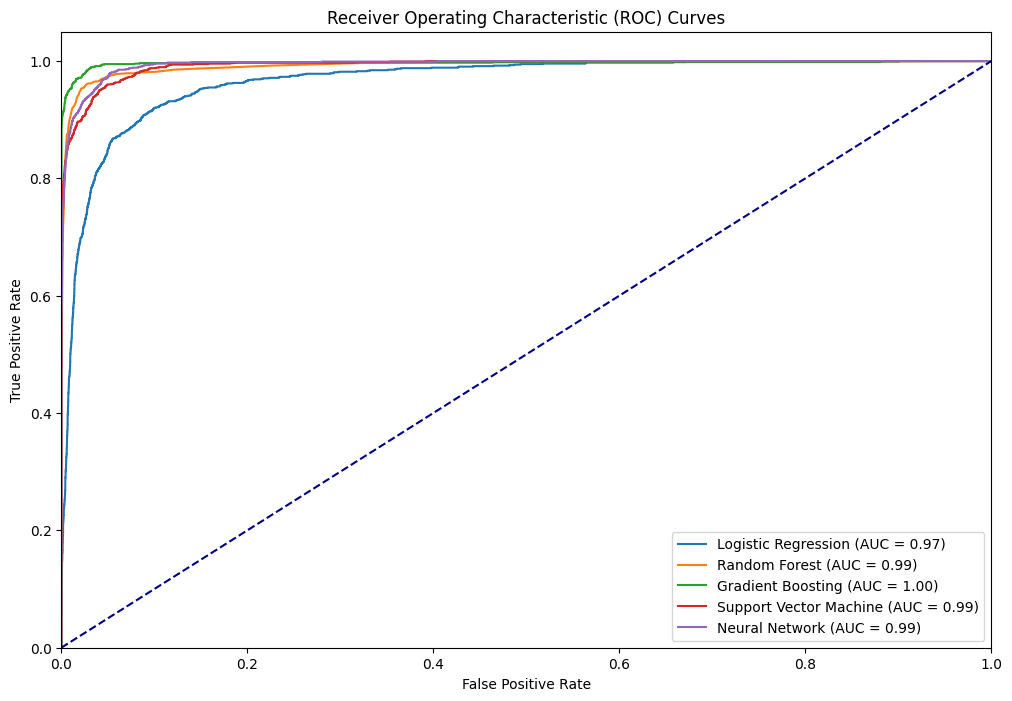

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


## Step 13: Precision-Recall Curves

We plot Precision-Recall curves for each model to evaluate their performance.


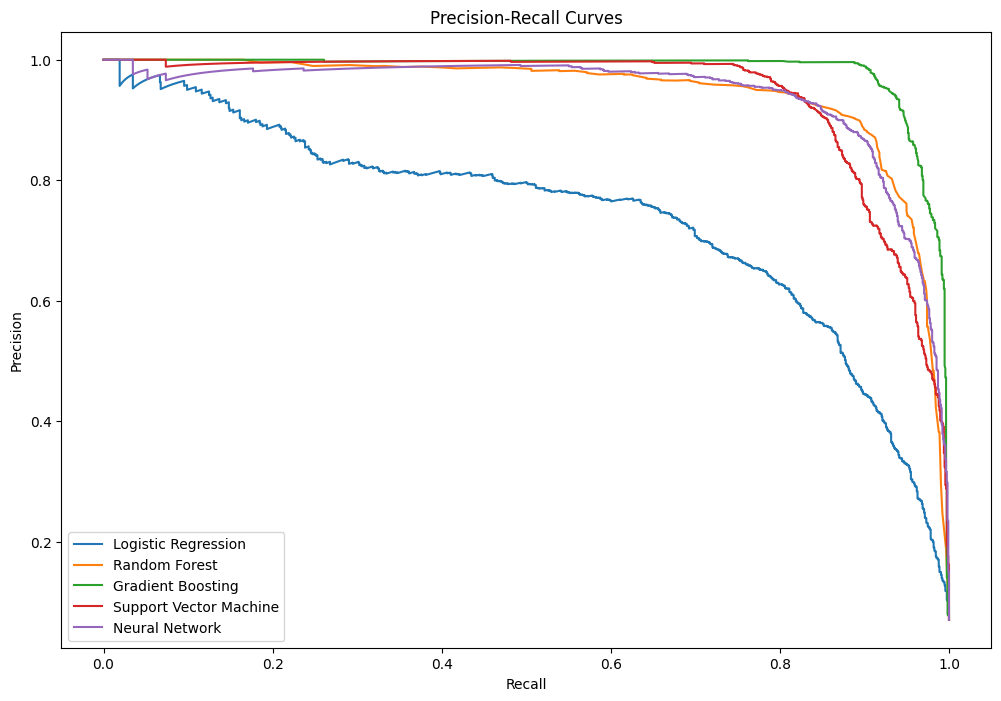

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()


## Step 14: Confusion Matrices

We plot confusion matrices for each model to visualize their performance.


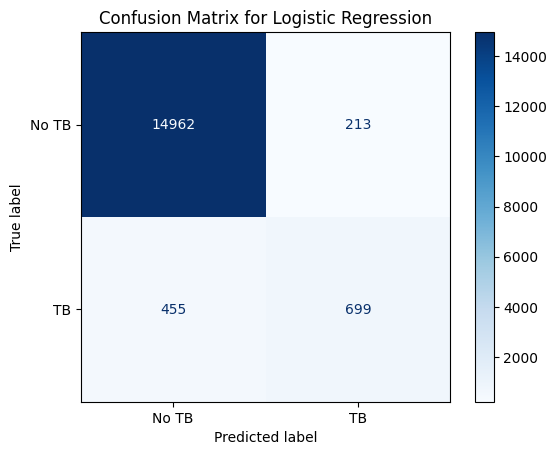

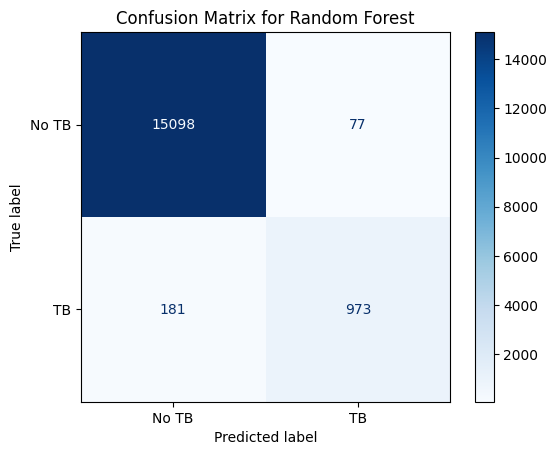

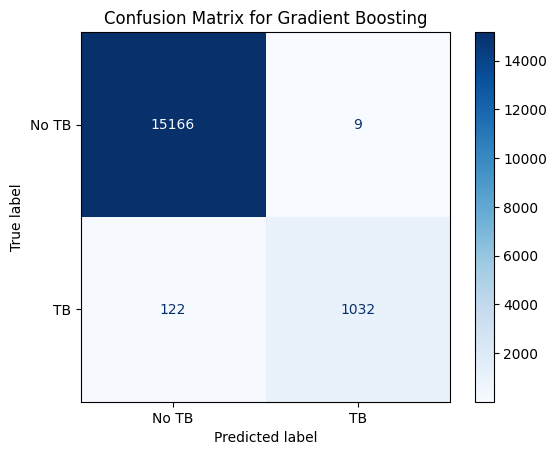

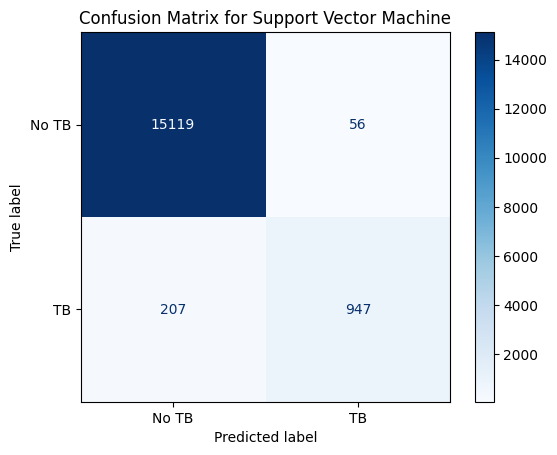

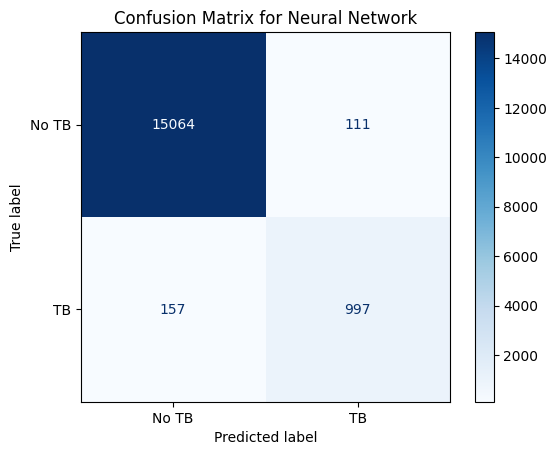

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrices(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Assuming you have a preprocessor step defined
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No TB', 'TB'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

# Plot confusion matrices for all models
plot_confusion_matrices(models, X_train, y_train, X_test, y_test)


## Step 15: Learning Curves

We plot learning curves for each model to understand their learning behavior.


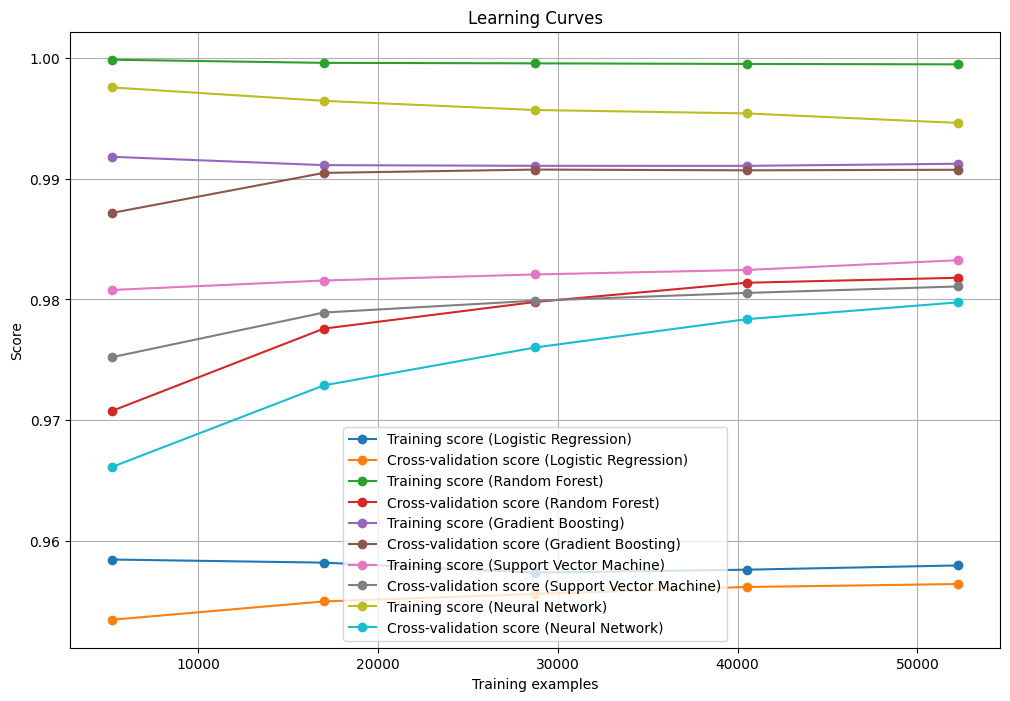

In [ ]:
from sklearn.model_selection import learning_curve

plt.figure(figsize=(12, 8))
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f'Training score ({name})')
    plt.plot(train_sizes, test_scores_mean, 'o-', label=f'Cross-validation score ({name})')

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid()
plt.show()


## Step 16: Calibration Curves

We plot calibration curves for each model to evaluate the reliability of their predicted probabilities.



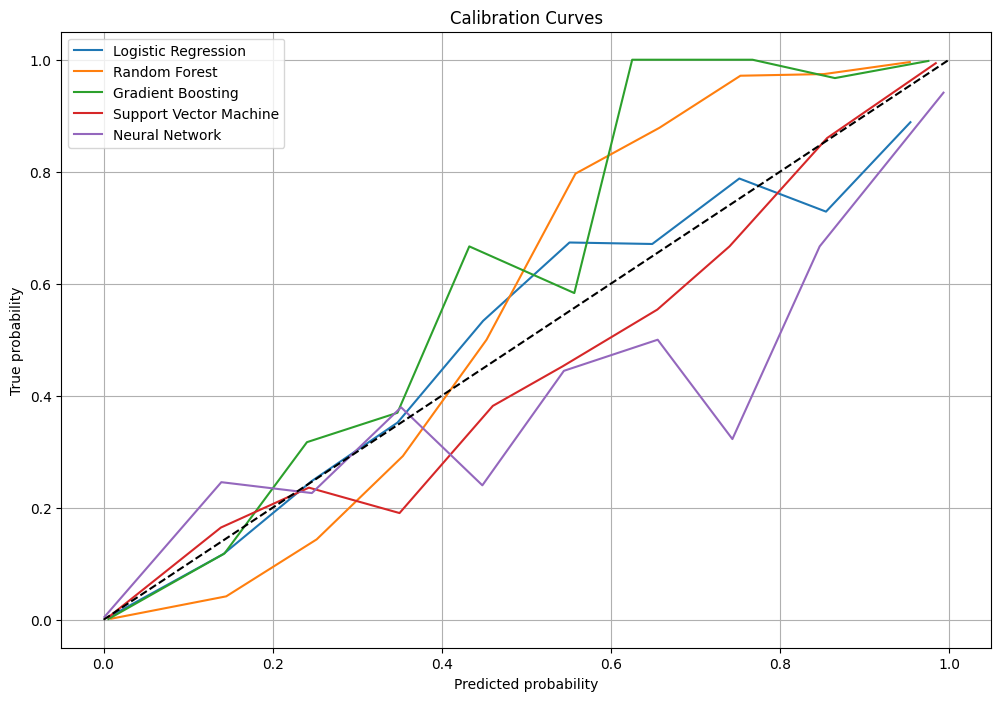

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each model to plot its calibration curve
for name, model in models.items():
    # Create a pipeline with preprocessing and the current model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    # Predict probabilities for the test data
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    # Compute true and predicted probabilities for calibration
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    # Plot the calibration curve
    plt.plot(prob_pred, prob_true, label=f'{name}')

# Plot the perfectly calibrated line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curves')
plt.legend(loc='best')
plt.grid()
plt.show()
